In [1]:
import pandas as pd
import numpy as np
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns #heat map
from scipy.stats import pearsonr 


In [2]:
Range = np.power(2,6)

In [3]:
L_range = np.linspace(0, 1.5, num=Range)
am_range = np.linspace(np.pi, np.pi/2, num=Range)
an_range = np.linspace(0, np.pi/2, num=Range)

L_grid, am_grid, an_grid = np.meshgrid(L_range, am_range, an_range)


In [4]:
#Create two functions of dx and dy so we can link and evaluate how they change with different parameters


def dx(L,am,an):
    return 2 * L * np.sin(0.25*(am - an)) * np.cos(0.25*(am + an))

def dy(L,am,an):
    return (-2) * L *np.sin(0.25*(an + am)) * np.sin(0.25*(an - am))



In [5]:
# 4. Create initial DataFrame
df = pd.DataFrame({
    'L': L_grid.ravel(),
    'am': am_grid.ravel(),
    'an': an_grid.ravel()
})

df['DX']=dx(df['L'],df['am'],df['an'])
df['DY']=dy(df['L'],df['am'],df['an'])
df_filtered = df[df['DX'] > 0.250].copy()


In [6]:
# See the first 5 rows
print(df_filtered.head())

# See the first 20 rows
print(df_filtered.head(20))

# See the last 5 rows
print(df_filtered.tail())

            L        am        an        DX        DY
704  0.261905  3.141593  0.000000  0.261905  0.261905
705  0.261905  3.141593  0.024933  0.258640  0.261884
706  0.261905  3.141593  0.049867  0.255375  0.261823
707  0.261905  3.141593  0.074800  0.252112  0.261722
768  0.285714  3.141593  0.000000  0.285714  0.285714
            L        am        an        DX        DY
704  0.261905  3.141593  0.000000  0.261905  0.261905
705  0.261905  3.141593  0.024933  0.258640  0.261884
706  0.261905  3.141593  0.049867  0.255375  0.261823
707  0.261905  3.141593  0.074800  0.252112  0.261722
768  0.285714  3.141593  0.000000  0.285714  0.285714
769  0.285714  3.141593  0.024933  0.282152  0.285692
770  0.285714  3.141593  0.049867  0.278591  0.285625
771  0.285714  3.141593  0.074800  0.275031  0.285514
772  0.285714  3.141593  0.099733  0.271473  0.285359
773  0.285714  3.141593  0.124666  0.267916  0.285159
774  0.285714  3.141593  0.149600  0.264363  0.284915
775  0.285714  3.141593  0.1

In [7]:

maov = MANOVA.from_formula('DX + DY ~ L + am + an', data=df_filtered)
mv_test=maov.mv_test()

print(maov.mv_test())

                      Multivariate linear model
                                                                     
---------------------------------------------------------------------
        Intercept        Value  Num DF    Den DF     F Value   Pr > F
---------------------------------------------------------------------
           Wilks' lambda 0.1521 2.0000 158004.0000 440422.3918 0.0000
          Pillai's trace 0.8479 2.0000 158004.0000 440422.3918 0.0000
  Hotelling-Lawley trace 5.5748 2.0000 158004.0000 440422.3918 0.0000
     Roy's greatest root 5.5748 2.0000 158004.0000 440422.3918 0.0000
---------------------------------------------------------------------
                                                                     
---------------------------------------------------------------------
           L             Value  Num DF    Den DF     F Value   Pr > F
---------------------------------------------------------------------
          Wilks' lambda  0.0790 2.0000 158

In [8]:
#sensitivity DX

def sensitivity(inputs, output):
    S = []
    for i in range(inputs.shape[1]):
        r, _ = pearsonr(inputs[:,i], output)
        S.append(abs(r))
    S = np.array(S)
    return S / S.sum()

inputs = df_filtered[['L', 'am', 'an']].values
output_dx = df_filtered['DX'].values

# Run your sensitivity function
s_indices = sensitivity(inputs, output_dx)

# Create a clean summary
sensitivity_df = pd.DataFrame({
    'Variable': ['L', 'am', 'an'],
    'Sensitivity_Index': s_indices
})

print(sensitivity_df)

  Variable  Sensitivity_Index
0        L           0.460159
1       am           0.117308
2       an           0.422533


In [9]:
#sensitivity DY

def sensitivity(inputs, output):
    S = []
    for i in range(inputs.shape[1]):
        r, _ = pearsonr(inputs[:,i], output)
        S.append(abs(r))
    S = np.array(S)
    return S / S.sum()

inputs = df_filtered[['L', 'am', 'an']].values
output_dy = df['DY'].values

# Run your sensitivity function
s_indices = sensitivity(inputs, output_dx)

# Create a clean summary
sensitivity_df = pd.DataFrame({
    'Variable': ['L', 'am', 'an'],
    'Sensitivity_Index': s_indices
})

print(sensitivity_df)

  Variable  Sensitivity_Index
0        L           0.460159
1       am           0.117308
2       an           0.422533


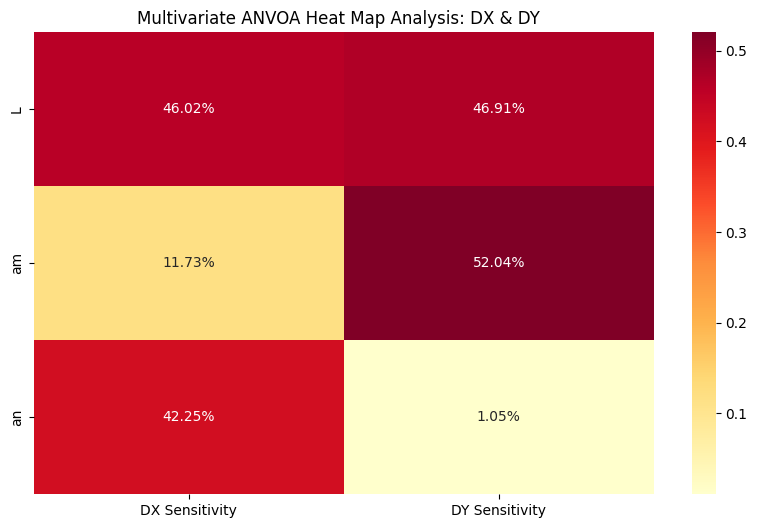

In [10]:

# 1. Define inputs for the filtered data
ivs = ['L', 'am', 'an']
X_data = df_filtered[ivs].values

# 2. Run your sensitivity function for both targets
sens_dx = sensitivity(X_data, df_filtered['DX'].values)
sens_dy = sensitivity(X_data, df_filtered['DY'].values)

# 3. Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'DX Sensitivity': sens_dx,
    'DY Sensitivity': sens_dy
}, index=ivs)

# 4. Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(comparison_df, annot=True, fmt=".2%", cmap='YlOrRd')
plt.title('Multivariate ANVOA Heat Map Analysis: DX & DY  ')
plt.show()

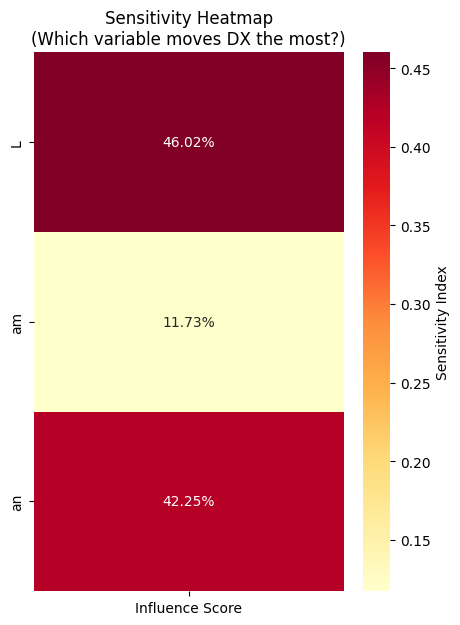

In [11]:
#Heat Map DX

inputs = df_filtered[['L', 'am', 'an']].values
output_dx = df_filtered['DX'].values
s_indices = sensitivity(inputs, output_dx)

# 2. Format the data for a Heatmap
# We create a 1-column DataFrame where the rows are L, am, and an
sensitivity_results = pd.DataFrame(s_indices, index=['L', 'am', 'an'], columns=['Influence Score'])

# 3. Create the Heat Graph
plt.figure(figsize=(5, 7))
sns.heatmap(sensitivity_results, annot=True, fmt=".2%", cmap="YlOrRd", cbar_kws={'label': 'Sensitivity Index'})

plt.title('Sensitivity Heatmap\n(Which variable moves DX the most?)')
plt.show()

In [12]:
#Heat Map DY

inputs = df_filtered[['L', 'am', 'an']].values
output_dx = df['DY'].values
s_indices = sensitivity(inputs, output_dx)

# 2. Format the data for a Heatmap
# We create a 1-column DataFrame where the rows are L, am, and an
sensitivity_results = pd.DataFrame(s_indices, index=['L', 'am', 'an'], columns=['Influence Score'])

# 3. Create the Heat Graph
plt.figure(figsize=(5, 7))
sns.heatmap(sensitivity_results, annot=True, fmt=".2%", cmap="YlOrRd", cbar_kws={'label': 'Sensitivity Index'})

plt.title('Sensitivity Heatmap\n(Which variable moves DY the most?)')
plt.show()

ValueError: `x` and `y` must be broadcastable.